# Banjul Accessibility Analysis

- This analysis will measure accessibility to schools and hospitals
- origins are derived from 100m grid blocks coming from WorldPop
- the accessibility measure is the time to the nearest facility in seconds

## Inputs:

#### origins: derived from a WorldPOP raster using the 'Raster pixels to Points' tool in QGIS 3, and saved as a shapefile
#### destinations: The combination of POIs from Overpass as points and centroids of polygons called through the GOSTNets OSMNX_POIs library.
#### The admin AOI will be used to create a bounding box to download the road network via OSMNX


### Import libraries

In [85]:
import sys, os, inspect, logging, importlib

import geopandas as gpd
import pandas as pd
import numpy as np
import osmnx as ox
import networkx as nx
from shapely.ops import split, unary_union
from shapely.geometry import box, Point

import matplotlib.pyplot as plt

In [86]:
# Get reference to OSMNX_POIs
sys.path.append(r'../..')
from Market_Access import OSMNX_POIs

In [87]:
# Get reference to GOSTNets
sys.path.append(r'../../GOSTNets/GOSTNets')
import GOSTnet as gn

In [88]:
# define output folder
inputFolder = r'input_folder'
# define output folder
outputFolder = r'../../../banjul_output_folder'
# define road graph
roadGraph = os.path.join(inputFolder, "OSM_Roads.pickle")

In [89]:
# import extent
city_extent = gpd.read_file(os.path.join(inputFolder, "Banjul_AOI.shp"))

In [90]:
# make sure crs is 4326
print(city_extent.crs)

{'init': 'epsg:4326'}


In [91]:
extent = box(*city_extent.total_bounds)

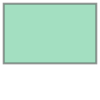

In [92]:
extent

## We will extract OSM POIs

In [93]:
schools_query = OSMNX_POIs.AmenityObject('education', extent, ['school', 'kindergarten','university', 'college'], inputFolder)        

In [94]:
health_query = OSMNX_POIs.AmenityObject('health ', extent, ['clinic','pharmacy','hospital','health'], inputFolder)        

In [95]:
school_destinations = schools_query.GenerateOSMPOIs()
health_destinations = health_query.GenerateOSMPOIs()

In [96]:
#destinations[["osmid"]]
#destinations[["name"]]

In [97]:
#list(school_destinations.columns)

In [98]:
#list(health_destinations.columns)

In [99]:
# warining: might not want to include the 'osmid' field because it may contain lists
school_destinations = school_destinations[['amenity','geometry','name']]
health_destinations = health_destinations[['amenity','geometry','name']]

In [100]:
school_destinations[:3]

,amenity,geometry,name
0,school,POINT (-16.6936882 13.4698014),Ecole Française
1,school,POINT (-16.7474028 13.397388),Brufut Senior Secondary School
2,school,POINT (-16.6760761 13.4468343),St Theresa's School


In [101]:
# save the facilities as a shapefile
# if not os.path.exists(outputFolder + '/osm_infrastructure/OSM_schools.shp'):

# convert to GeoDataFrame
school_destinations_gpd = gpd.GeoDataFrame(school_destinations, crs = "epsg:4326", geometry = 'geometry')
school_destinations_gpd.to_file(outputFolder + '/osm_infrastructure/osm_schools.shp')

health_destinations_gpd = gpd.GeoDataFrame(health_destinations, crs = "epsg:4326", geometry = 'geometry')
health_destinations_gpd.to_file(outputFolder + '/osm_infrastructure/osm_health.shp')

## We will extract the Roads and convert into a graph

In [102]:
# This is the section where we can adjust the road speeds
if not os.path.exists(roadGraph):
    extent = box(*city_extent.total_bounds)
    G = ox.graph_from_polygon(extent, network_type = 'drive_service')
    # This is how time is calculated from the OSMNX length attribute
    G = gn.convert_network_to_time(G, 'length')
    # save the largerst subgraph
    list_of_Gs = list((nx.strongly_connected_component_subgraphs(G)))
    sz = 0
    largest_G = list_of_Gs[0]
    for g in list_of_Gs:
        curSize = g.size()
        if curSize > sz:
            largest_G = g
            sz = curSize
    G = largest_G
    print('print G')
    print(sz)
    nx.write_gpickle(G, roadGraph)
else:
    G = nx.read_gpickle(roadGraph)    
    G = gn.convert_network_to_time(G, 'length')

### Inspect the road graph as a shapefile

In [103]:
roads = gn.edge_gdf_from_graph(G)

In [104]:
roads[:2]

,stnode,endnode,mode,oneway,lanes,service,bridge,access,length,name,maxspeed,osmid,time,highway,junction,geometry
0,1254588416,3833555169,drive,False,NaN,NaN,NaN,NaN,24.330,NaN,NaN,109643138,4.37940,residential,NaN,"LINESTRING (-16.6975914 13.4213108, -16.697753..."
1,1254588416,1254588099,drive,False,NaN,NaN,NaN,NaN,74.157,NaN,NaN,109643138,13.34826,residential,NaN,"LINESTRING (-16.6975914 13.4213108, -16.697436..."


In [105]:
if not os.path.exists(outputFolder + '/OSM_Roads/OSM_Roads.shp'):
    roads['oneway'] = roads.oneway.astype(int)
    roads = roads[['oneway','length','time','mode','geometry']]
    roads.to_file(outputFolder + '/OSM_Roads')

## Create origins and destinations and snap them to the road graph

In [106]:
# insert origins
origins = gpd.read_file(os.path.join(inputFolder, "banjul_worldpop_pts.shp"))

In [107]:
# snap the origins to the road graph
snapped_origins = gn.pandana_snap(G, origins)

../../GOSTNets/GOSTNets/GOSTnet.py:1716: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  G_tree = spatial.KDTree(node_gdf[['x','y']].as_matrix())
../../GOSTNets/GOSTNets/GOSTnet.py:1718: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  distances, indices = G_tree.query(in_df[['x','y']].as_matrix())


In [108]:
originNodes = list(snapped_origins['NN'].unique())

In [109]:
# snap the destinations to the road graph
snapped_school_destinations = gn.pandana_snap(G, school_destinations)
snapped_health_destinations = gn.pandana_snap(G, health_destinations)

In [110]:
school_destinationNodes = list(snapped_school_destinations['NN'].unique())
health_destinationNodes = list(snapped_health_destinations['NN'].unique())

In [111]:
# calculate OD matrix
school_OD_matrix = gn.calculate_OD(G, originNodes, school_destinationNodes, fail_value=-1, weight='time')
health_OD_matrix = gn.calculate_OD(G, originNodes, health_destinationNodes, fail_value=-1, weight='time')

In [112]:
#OD_matrix[:3]

In [113]:
# testing
# school_closest_facility_per_origin = school_OD_matrix.min(axis=1)
# school_closest_facility_per_origin[:5]

In [114]:
# calculate accessibility
# For each row, the closest facility is the smallest value in the row

output = snapped_origins.copy()

school_closest_facility_per_origin = school_OD_matrix.min(axis=1)
health_closest_facility_per_origin = health_OD_matrix.min(axis=1)

school_results = pd.DataFrame([originNodes, school_closest_facility_per_origin]).transpose()
health_results = pd.DataFrame([originNodes, health_closest_facility_per_origin]).transpose()

colName = "travel_time_to_closest_facility"
school_results.columns = ['NN', colName]
health_results.columns = ['NN', colName]

In [115]:
#results[:5]

In [116]:
school_output = pd.merge(output, school_results, on="NN")
health_output = pd.merge(output, health_results, on="NN")

In [117]:
school_output.to_csv(os.path.join(outputFolder, "banjul_accessibility_schools.csv"))

In [118]:
health_output.to_csv(os.path.join(outputFolder, "banjul_accessibility_health.csv"))